### Imports
Lots of these aren't necessary but I've copied and pasted it straight from the Explore gene.ipynb notebook.

In [1]:
import pandas as pd
import scipy.stats
import re

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np

from sklearn.metrics import confusion_matrix

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=300 # dots per inch

### Cleaning calculatedProperties table

In [2]:
calculatedProperties = pd.read_csv("FH_complete_mutation_summary.csv")
calculatedProperties = calculatedProperties.drop(columns = ["Mutation","Unnamed: 0", "rhapsodyclass","rhapsodyscore","polyphenscore","polyphenclass"])

### Cleaning BayesDel table

In [3]:
BayesDel = pd.read_csv("./FH_mutations_BayesDel_Cleaned_2.csv")

# need to match column names to that of calculatedProperties
BayesDel.rename(columns={
    'aapos': 'Residue',
    'aaalt': 'AAto',
    'aaref': 'AAfrom'
}, inplace=True)

# there's only some tables I want to keep
BayesDel = BayesDel[["AAfrom","AAto","Residue","BayesDel_addAF_score","BayesDel_noAF_score","BayesDel_addAF_rankscore"]]

### Filtering out BayesDel data

In [4]:
BayesDel_benign = BayesDel[BayesDel['BayesDel_noAF_score'] < -0.057]
BayesDel_deleterious = BayesDel[BayesDel['BayesDel_noAF_score'] >= -0.057]

In [5]:
# converting tables to string to avoid potential errors
calculatedProperties = calculatedProperties.astype(str)
BayesDel_benign = BayesDel_benign.astype(str)
BayesDel_deleterious = BayesDel_deleterious.astype(str)

### Binary classification

In [6]:
# merging datasets to get ready for binary classification
bs_calc = BayesDel_benign.merge(calculatedProperties, on = ["Residue", "AAfrom", "AAto"])
ds_calc = BayesDel_deleterious.merge(calculatedProperties, on = ["Residue", "AAfrom", "AAto"])

In [7]:
# add source column to benign and deleterious tables for classification
bs_calc["source"] = "neutral"
ds_calc["source"] = "deleterious"

In [8]:
logreg_data = pd.concat([bs_calc, ds_calc])

logreg_data = pd.get_dummies(logreg_data, columns = ["source"], drop_first = False)

logreg_data

,AAfrom,AAto,Residue,BayesDel_addAF_score,BayesDel_noAF_score,BayesDel_addAF_rankscore,Foldx_energy,Rosetta_energy,average_energy,RSA,Mindist_bindingsiteA,Mindist_hinge,source_deleterious,source_neutral
0,L,V,507,0.125399,-0.0576501,0.66673,1.88196,2.48,2.18098,0.213414634,15.11647605,6.032148733,0,1
1,D,E,505,-0.0749932,-0.345499,0.40175,-0.333306,0.777,0.221847,0.63803681,18.71564022,10.63279724,0,1
2,D,E,505,-0.0749939,-0.3455,0.40175,-0.333306,0.777,0.221847,0.63803681,18.71564022,10.63279724,0,1
3,D,N,505,-0.00212996,-0.240836,0.51039,-0.211858,0.82,0.304071,0.63803681,18.71564022,10.63279724,0,1
4,K,N,504,-0.0242995,-0.272681,0.47907,1.27046,3.16,2.21523,0.712195122,19.79394051,9.103497551,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2719,F,I,50,0.206988,0.0595479,0.74357,2.2606,1.613,1.9368,0.538071066,20.36104043,31.8387706,1,0
2720,S,F,49,0.206421,0.0587329,0.74302,0.18208,4.837,2.50954,0.992307692,23.46114822,33.71310025,1,0
2721,S,C,49,0.194834,0.0420892,0.73211,0.0673518,7.99,4.0286759,0.992307692,23.46114822,33.71310025,1,0
2722,S,Y,49,0.211915,0.0666251,0.74823,0.474099,4.829,2.6515495,0.992307692,23.46114822,33.71310025,1,0


In [9]:
## Look at all parameters - can sub the two energies for average
## (cant include all three as they are convoluted and the model then wont converge)
logreg_y = logreg_data[["source_deleterious"]]
logreg_x = logreg_data[["Foldx_energy", "Rosetta_energy", "average_energy","Mindist_bindingsiteA","Mindist_hinge","RSA"]]

logreg_x = logreg_x.astype(float)
plotting_frame = pd.concat([logreg_x, logreg_y], axis =1)

true_values = plotting_frame["source_deleterious"].to_list()

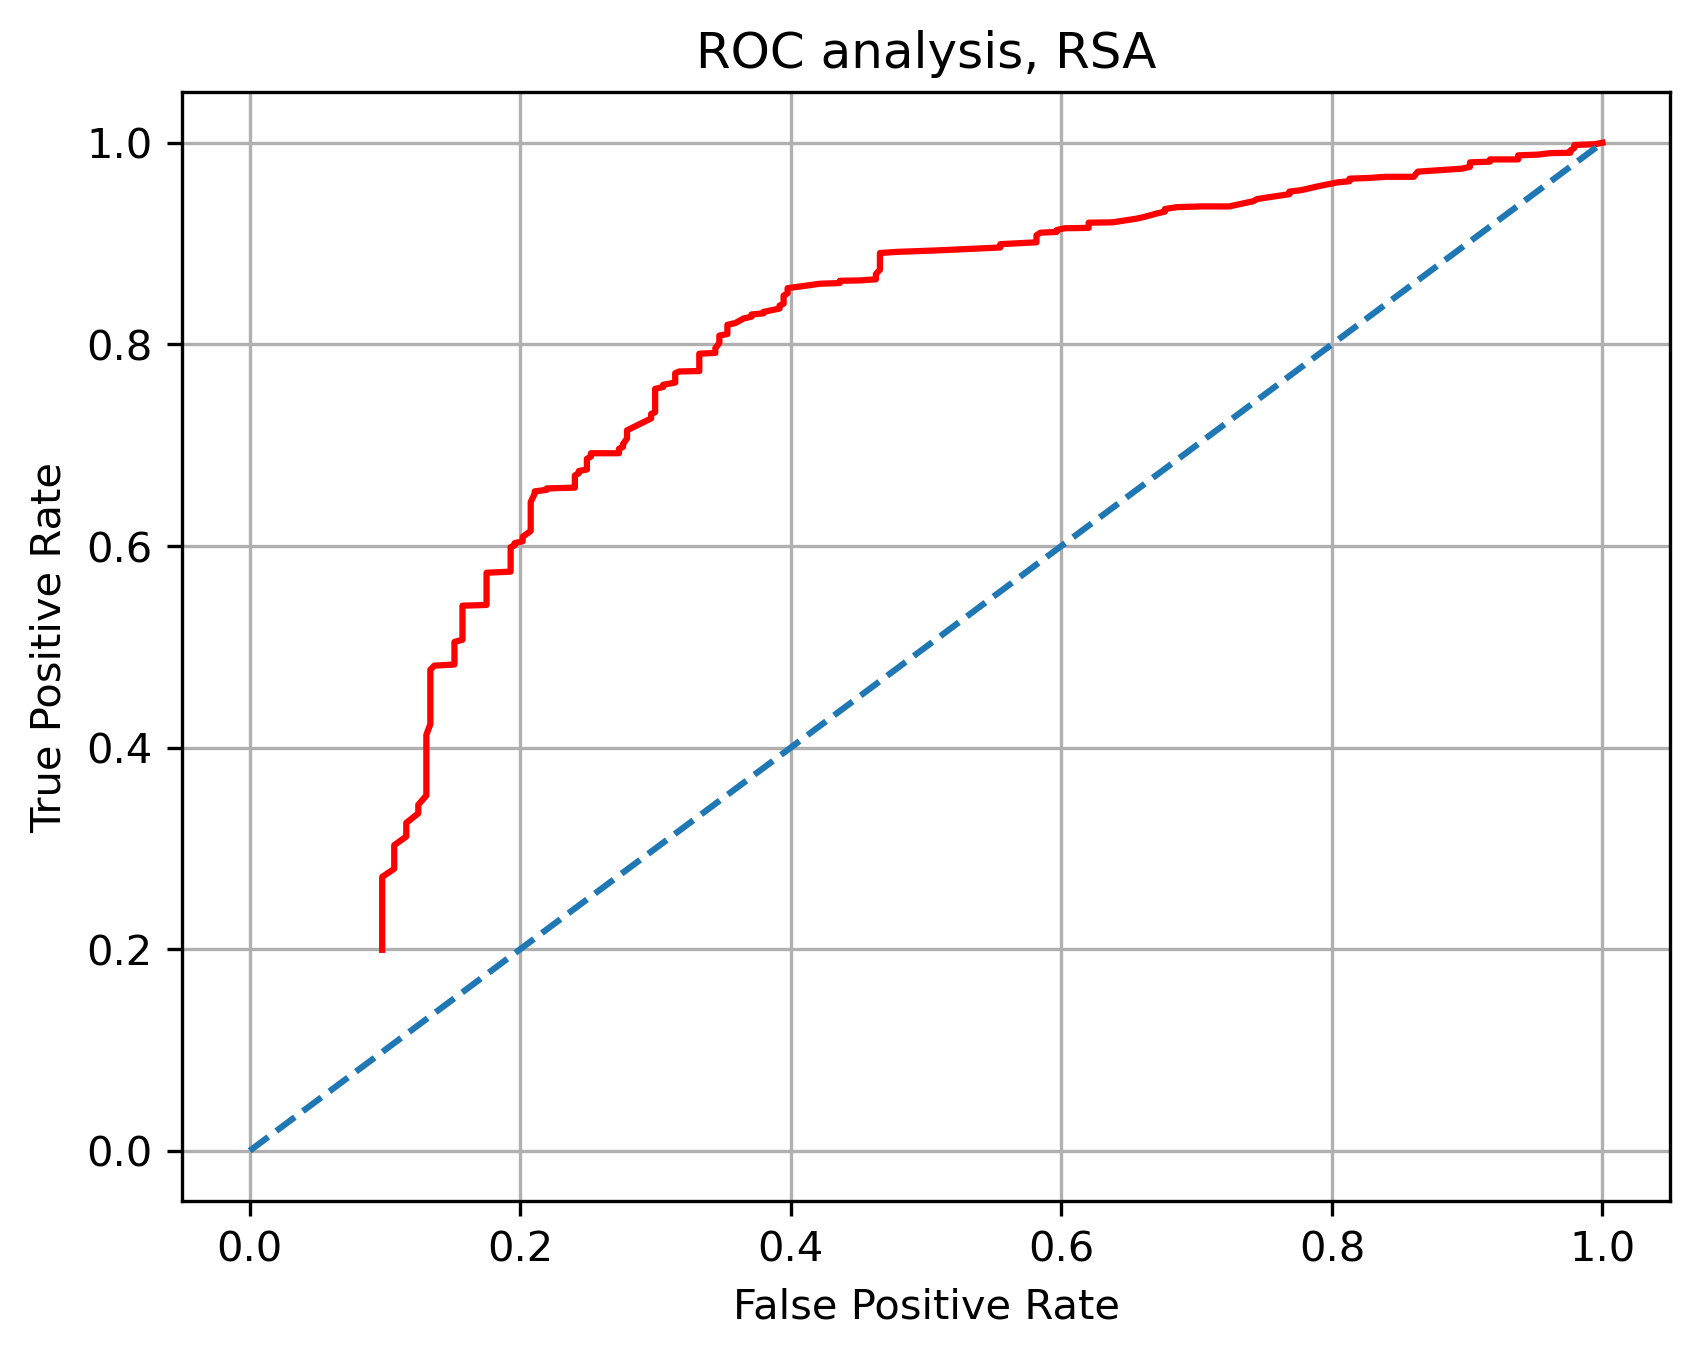

In [10]:
#fpr = dict()
#tpr = dict()
#roc_auc = dict()

## Generate the data for a roc curve
predlist = []
roc_curvedata = []
for i in np.arange(0,1, 0.001):
    pred = []
    for item in plotting_frame["RSA"]:
        predvalue = 1 if item <= i else 0 # This line determines which group everything is in-get it right!
        pred.append(predvalue)
    predlist.append(pred)
    fpr, tpr, _ = roc_curve(true_values, pred)
    roc_auc = auc(fpr, tpr)
    curvelist = [i, fpr[1], tpr[1], roc_auc]
    roc_curvedata.append(curvelist)
    
roc_dataframe = pd.DataFrame(roc_curvedata, columns=["threshold", "fpr", "tpr", "auc"])

fig,ax = plt.subplots()
g = plt.plot(roc_dataframe["fpr"], roc_dataframe["tpr"], c = "r")
g2 = plt.plot(np.arange(0,1.1, 0.1), np.arange(0,1.1,0.1), linestyle = "dashed")
#g.set_xlim(0,1)
#g.set_ylim(0,1.01)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC analysis, RSA")

plt.grid()
plt.show()

In [11]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
     display(roc_dataframe.sort_values(by="auc", ascending=False).head(3))

,threshold,fpr,tpr,auc
356,0.356,0.353116,0.819383,0.733134
355,0.355,0.353116,0.819383,0.733134
354,0.354,0.353116,0.819383,0.733134


### Investigating accuracies, FP/FN

In [12]:
cutoff= 0.356

ds_calc_noRSA = ds_calc[ds_calc["RSA"].astype(float)>=cutoff]
print("fraction deleterious which are removed", len(ds_calc_noRSA)/len(ds_calc)) 

bs_calc_noRSA = bs_calc[bs_calc["RSA"].astype(float)>=cutoff] 
print("fraction benign that remain", len(bs_calc_noRSA)/len(bs_calc))

print(" ")

TN = len(bs_calc_noRSA) # cases correctly classified as benign
FP = len(ds_calc_noRSA) # deleterious cases incorrectly classified as not deleterious
TP = len(ds_calc)-FP # cases correctly classed as deleterious
FN = len(bs_calc)-TN # benign cases incorrectly classified as not benign

#accuracy = (TP+TN)/(TP+TN+FP+FN)
print("Accuracy:",(TP+TN)/(TP+TN+FP+FN))

#sensitivity = TP/(TP+FN)
print("Sensitivity:",TP/(TP+FN))

#specificity = TN/(TN+FP)
print("Specificity:",TN/(TN+FP))

print(" ")

print("Amount of deleterious cases incorrectly classified:",FP)
print("Amount of deleterious cases correctly classified:", TP)
print("Amount of benign cases falsely classified:",FN)
print("Amount of benign cases correctly classified:",TN)

fraction deleterious which are removed 0.18061674008810572
fraction benign that remain 0.6468842729970327
 
Accuracy: 0.8003920287487749
Sensitivity: 0.9493832411739686
Specificity: 0.30704225352112674
 
Amount of deleterious cases incorrectly classified: 492
Amount of deleterious cases correctly classified: 2232
Amount of benign cases falsely classified: 119
Amount of benign cases correctly classified: 218


### Repeating logistic regression

In [13]:
logreg_data = pd.concat([bs_calc_noRSA, ds_calc_noRSA])

logreg_data = pd.get_dummies(logreg_data, columns = ["source"], drop_first = False)

logreg_data

,AAfrom,AAto,Residue,BayesDel_addAF_score,BayesDel_noAF_score,BayesDel_addAF_rankscore,Foldx_energy,Rosetta_energy,average_energy,RSA,Mindist_bindingsiteA,Mindist_hinge,source_deleterious,source_neutral
1,D,E,505,-0.0749932,-0.345499,0.40175,-0.333306,0.777,0.221847,0.63803681,18.71564022,10.63279724,0,1
2,D,E,505,-0.0749939,-0.3455,0.40175,-0.333306,0.777,0.221847,0.63803681,18.71564022,10.63279724,0,1
3,D,N,505,-0.00212996,-0.240836,0.51039,-0.211858,0.82,0.304071,0.63803681,18.71564022,10.63279724,0,1
4,K,N,504,-0.0242995,-0.272681,0.47907,1.27046,3.16,2.21523,0.712195122,19.79394051,9.103497551,0,1
5,K,N,504,-0.0242946,-0.272674,0.47907,1.27046,3.16,2.21523,0.712195122,19.79394051,9.103497551,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2719,F,I,50,0.206988,0.0595479,0.74357,2.2606,1.613,1.9368,0.538071066,20.36104043,31.8387706,1,0
2720,S,F,49,0.206421,0.0587329,0.74302,0.18208,4.837,2.50954,0.992307692,23.46114822,33.71310025,1,0
2721,S,C,49,0.194834,0.0420892,0.73211,0.0673518,7.99,4.0286759,0.992307692,23.46114822,33.71310025,1,0
2722,S,Y,49,0.211915,0.0666251,0.74823,0.474099,4.829,2.6515495,0.992307692,23.46114822,33.71310025,1,0


In [14]:
## Look at all parameters - can sub the two energies for average
## (cant include all three as they are convoluted and the model then wont converge)
logreg_y = logreg_data[["source_deleterious"]]
# logreg_x = logreg_data[["Foldx_energy", "Rosetta_energy", "average_energy","Mindist_bindingsiteA","Mindist_hinge","RSA"]]
logreg_x = logreg_data[["Foldx_energy", "Rosetta_energy","average_energy","Mindist_bindingsiteA","Mindist_hinge"]]

logreg_x = logreg_x.astype(float)
plotting_frame = pd.concat([logreg_x, logreg_y], axis =1)

true_values = plotting_frame["source_deleterious"].to_list()

### Looking at alternative metric Mindist_bindingsiteA

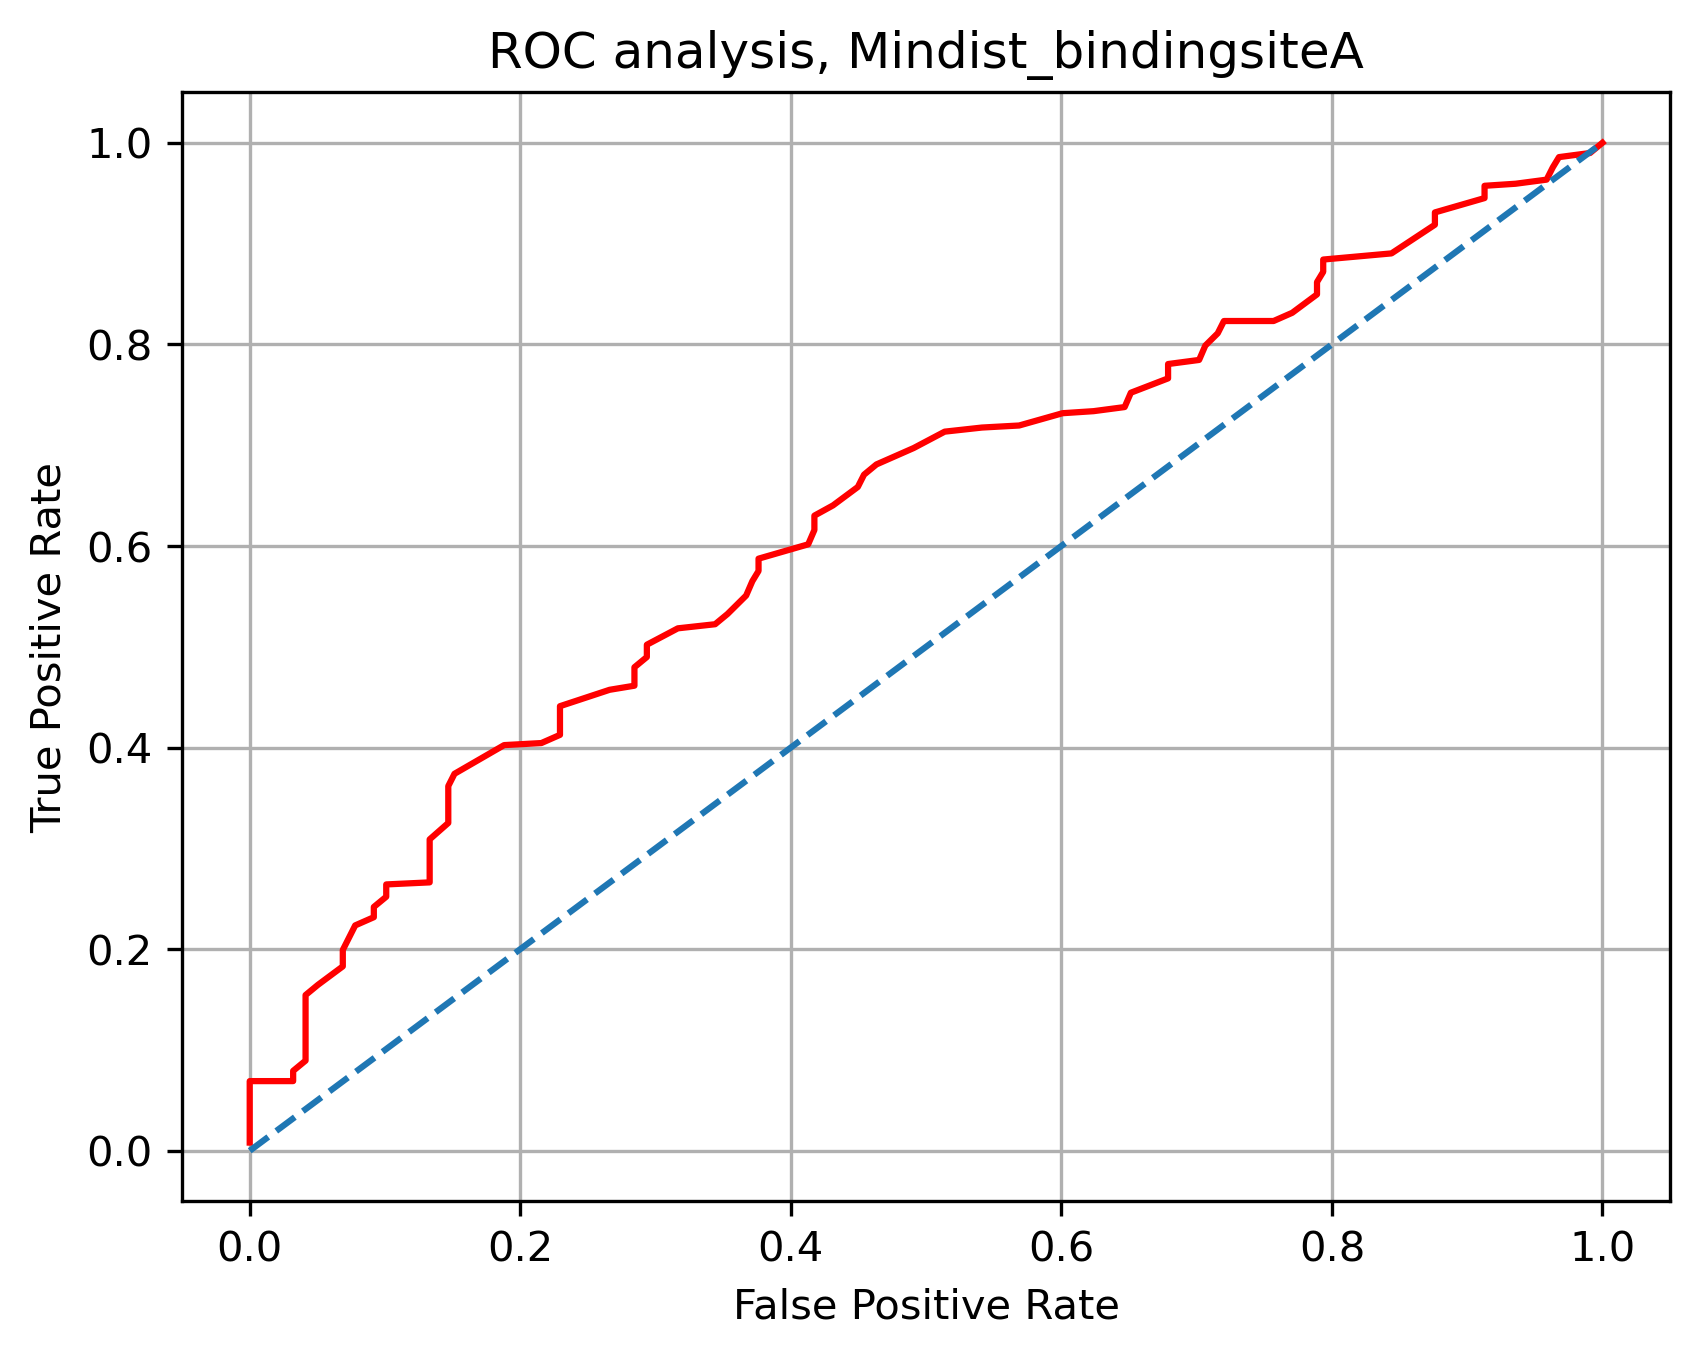

In [15]:
## Generate the data for a roc curve
predlist = []
roc_curvedata = []
for i in np.arange(0,100, 0.1):
    pred = []
    for item in plotting_frame["Mindist_bindingsiteA"]:
        predvalue = 1 if item <= i else 0 # This line determines which group everything is in-get it right!
        pred.append(predvalue)
    predlist.append(pred)
    fpr, tpr, _ = roc_curve(true_values, pred)
    roc_auc = auc(fpr, tpr)
    curvelist = [i, fpr[1], tpr[1], roc_auc]
    roc_curvedata.append(curvelist)
    
roc_dataframe = pd.DataFrame(roc_curvedata, columns=["threshold", "fpr", "tpr", "auc"])

fig,ax = plt.subplots()
g = plt.plot(roc_dataframe["fpr"], roc_dataframe["tpr"], c = "r")
g2 = plt.plot(np.arange(0,1.1, 0.1), np.arange(0,1.1,0.1), linestyle = "dashed")
#g.set_xlim(0,1)
#g.set_ylim(0,1.01)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC analysis, Mindist_bindingsiteA")

plt.grid()
plt.show()

In [16]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
     display(roc_dataframe.sort_values(by="auc", ascending=False).head(3))

,threshold,fpr,tpr,auc
148,14.8,0.151376,0.373984,0.611304
147,14.7,0.151376,0.373984,0.611304
192,19.2,0.463303,0.680894,0.608796


### Looking at alternative metric Mindist_hinge

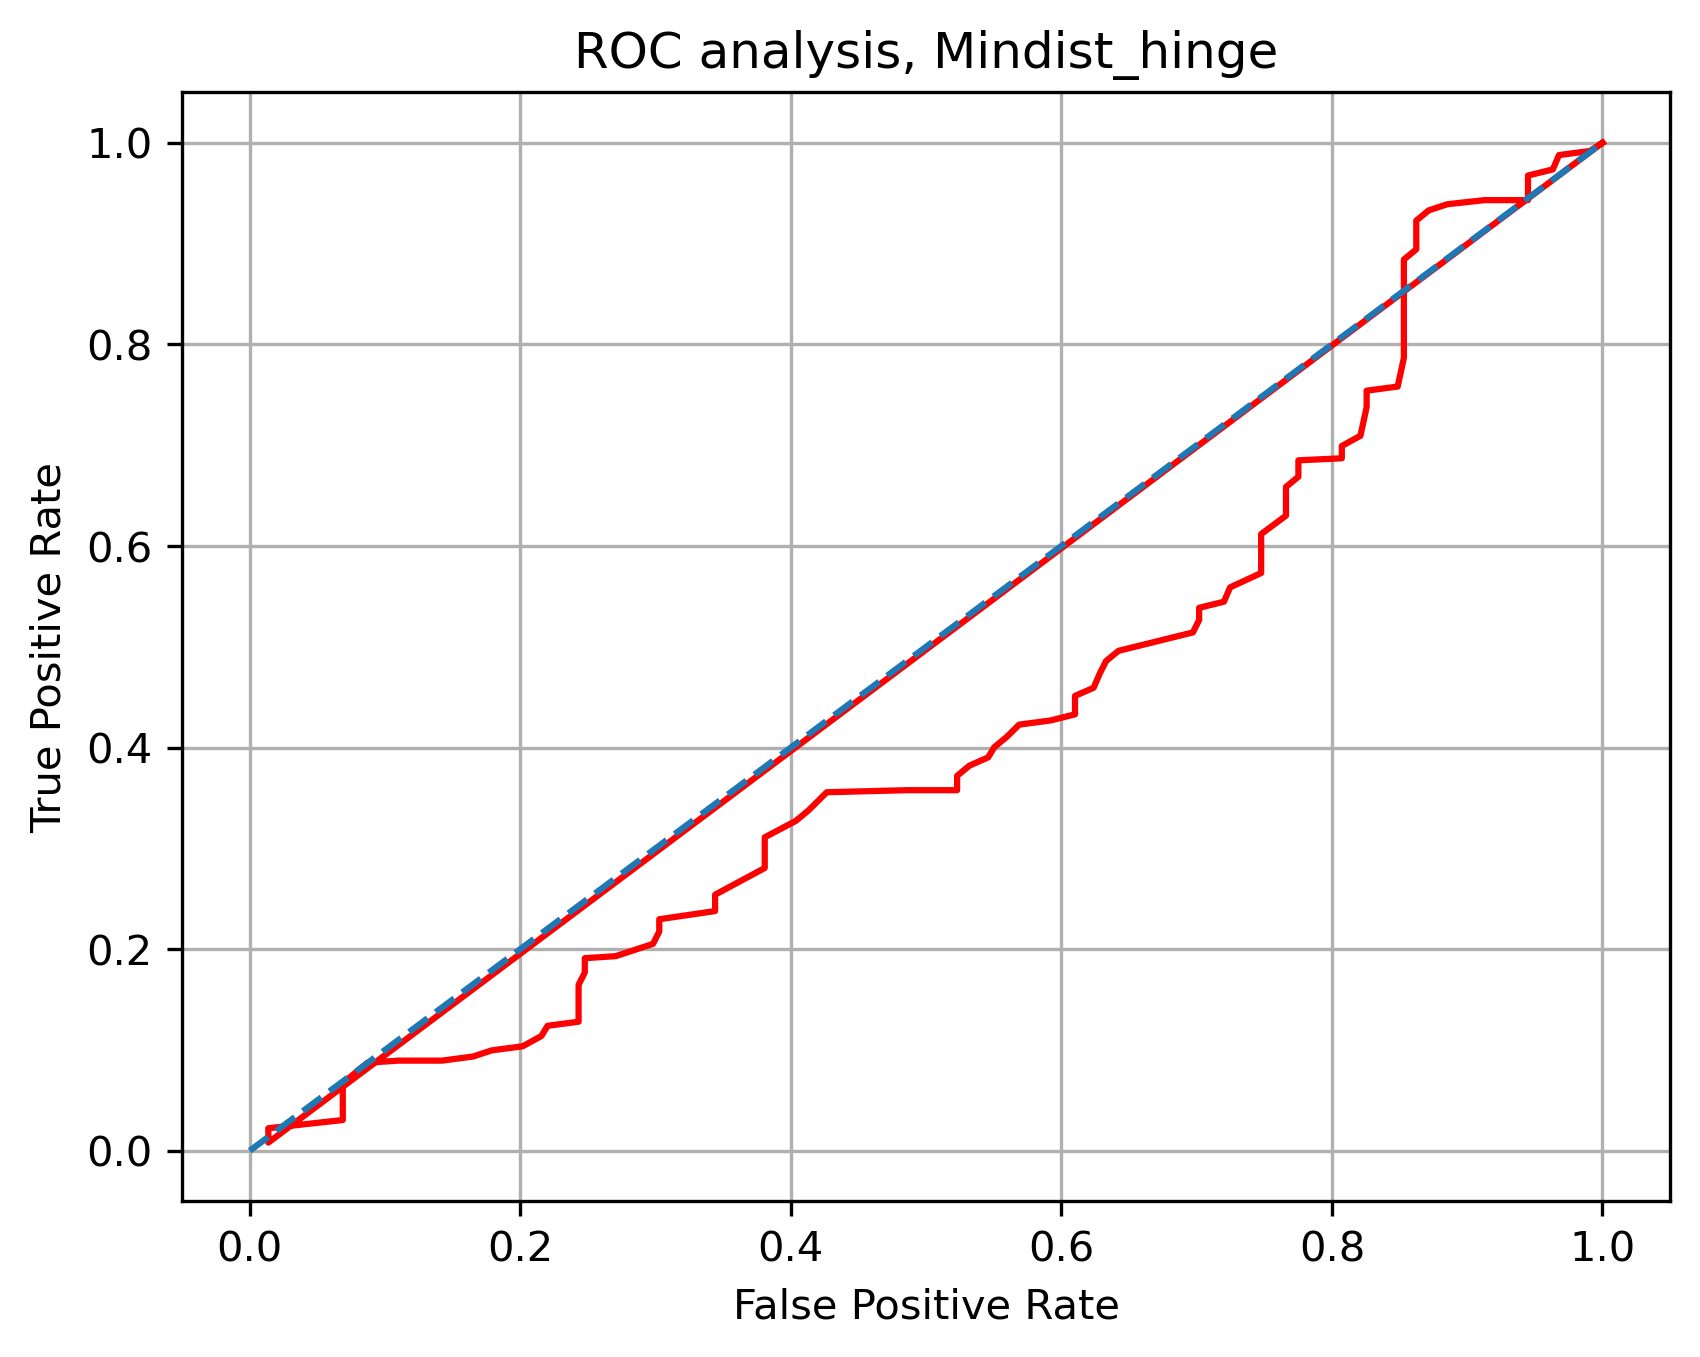

In [17]:
## Generate the data for a roc curve
predlist = []
roc_curvedata = []
for i in np.arange(0,100, 0.1):
    pred = []
    for item in plotting_frame["Mindist_hinge"]:
        predvalue = 1 if item <= i else 0 # This line determines which group everything is in-get it right!
        pred.append(predvalue)
    predlist.append(pred)
    fpr, tpr, _ = roc_curve(true_values, pred)
    roc_auc = auc(fpr, tpr)
    curvelist = [i, fpr[1], tpr[1], roc_auc]
    roc_curvedata.append(curvelist)
    
roc_dataframe = pd.DataFrame(roc_curvedata, columns=["threshold", "fpr", "tpr", "auc"])

fig,ax = plt.subplots()
g = plt.plot(roc_dataframe["fpr"], roc_dataframe["tpr"], c = "r")
g2 = plt.plot(np.arange(0,1.1, 0.1), np.arange(0,1.1,0.1), linestyle = "dashed")
#g.set_xlim(0,1)
#g.set_ylim(0,1.01)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC analysis, Mindist_hinge")

plt.grid()
plt.show()

In [18]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
     display(roc_dataframe.sort_values(by="auc", ascending=False).head(3))

,threshold,fpr,tpr,auc
291,29.1,0.87156,0.932927,0.530684
293,29.3,0.87156,0.932927,0.530684
290,29.0,0.87156,0.932927,0.530684


### Looking at alternative metric Foldx_energy

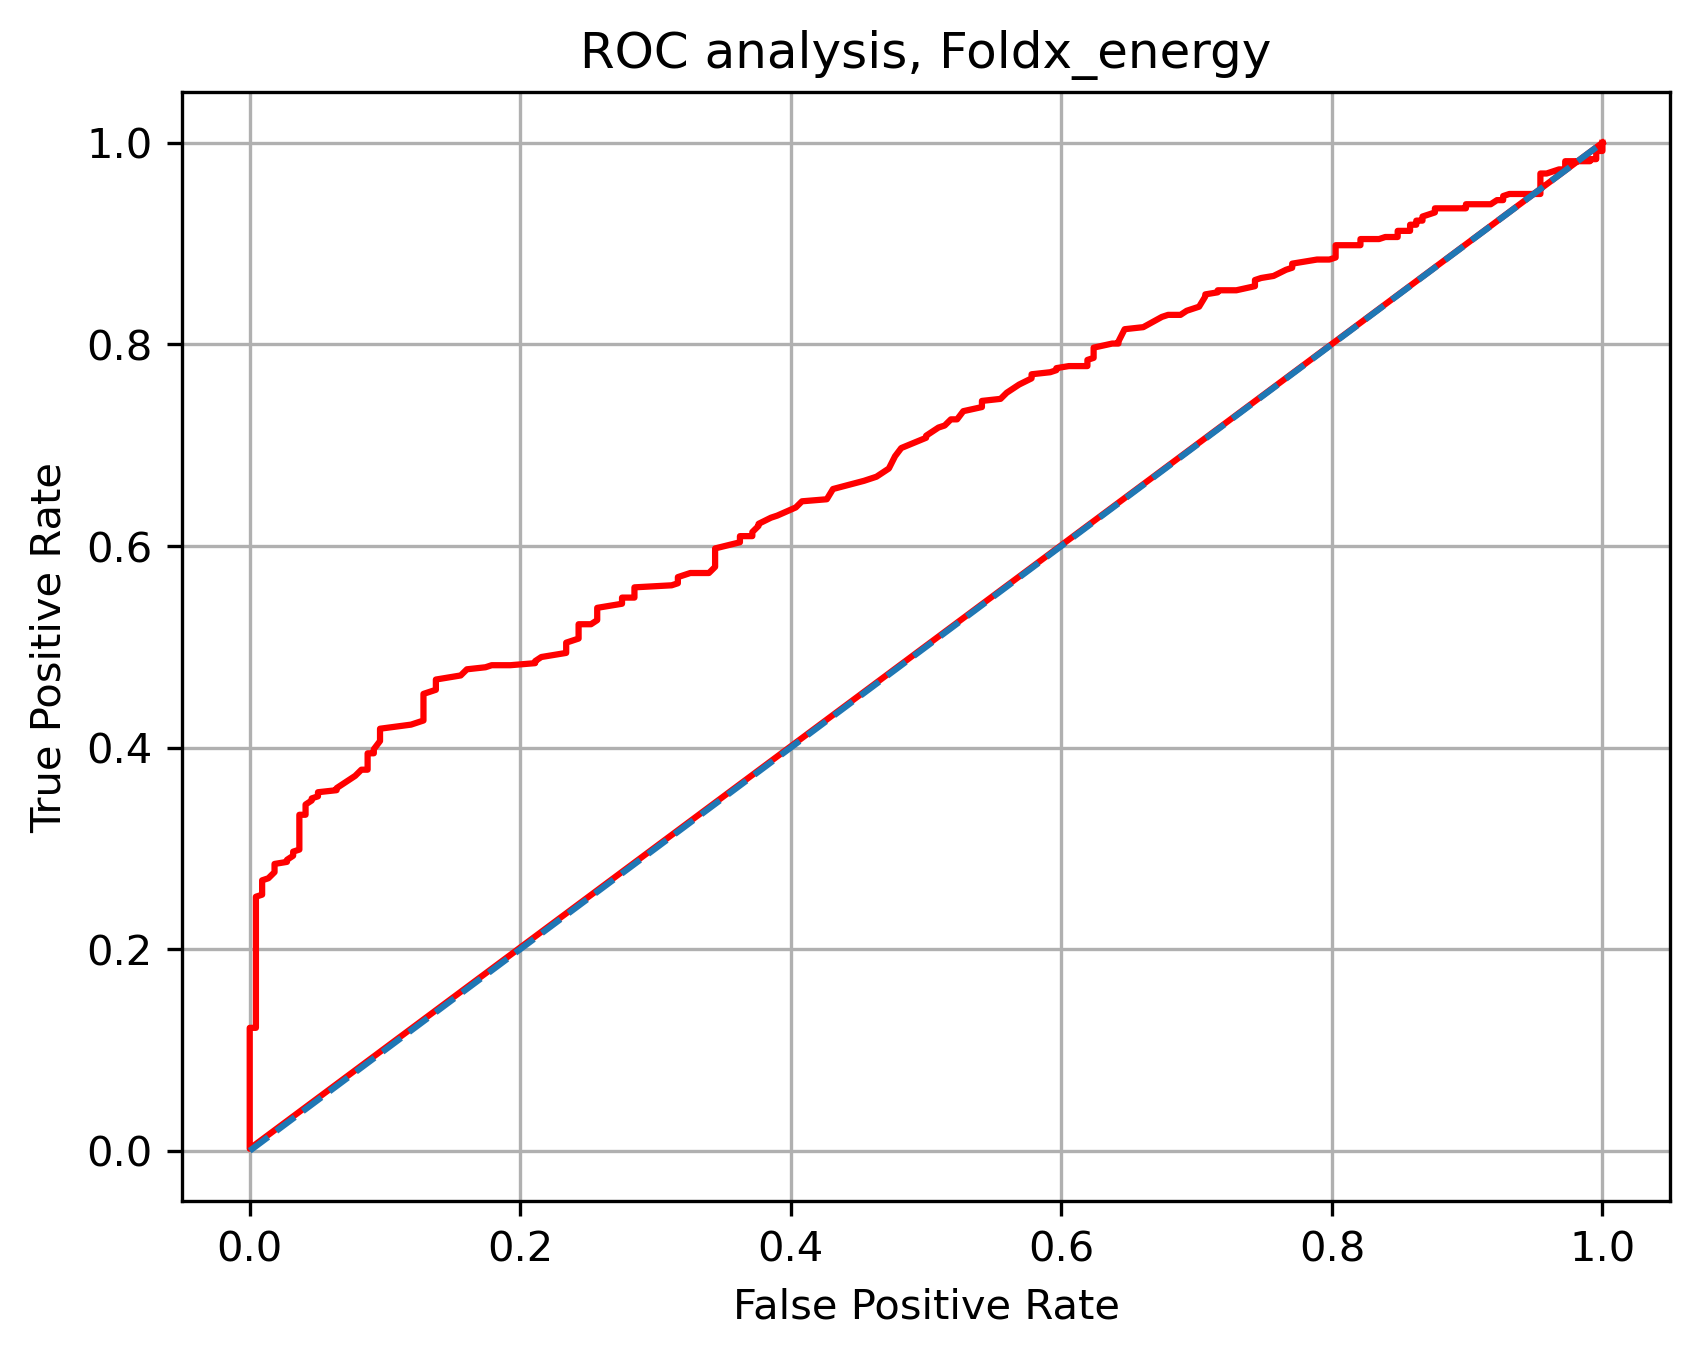

In [19]:
## Generate the data for a roc curve
predlist = []
roc_curvedata = []
for i in np.arange(-5,20, 0.01):
    pred = []
    for item in plotting_frame["Foldx_energy"]:
        predvalue = 1 if item >= i else 0 # This line determines which group everything is in-get it right!
        pred.append(predvalue)
    predlist.append(pred)
    fpr, tpr, _ = roc_curve(true_values, pred)
    roc_auc = auc(fpr, tpr)
    curvelist = [i, fpr[1], tpr[1], roc_auc]
    roc_curvedata.append(curvelist)
    
roc_dataframe = pd.DataFrame(roc_curvedata, columns=["threshold", "fpr", "tpr", "auc"])

fig,ax = plt.subplots()
g = plt.plot(roc_dataframe["fpr"], roc_dataframe["tpr"], c = "r")
g2 = plt.plot(np.arange(0,1.1, 0.1), np.arange(0,1.1,0.1), linestyle = "dashed")
#g.set_xlim(0,1)
#g.set_ylim(0,1.01)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC analysis, Foldx_energy")

plt.grid()
plt.show()

In [20]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
     display(roc_dataframe.sort_values(by="auc", ascending=False).head(3))

,threshold,fpr,tpr,auc
574,0.74,0.137615,0.467480,0.664932
575,0.75,0.137615,0.465447,0.663916
578,0.78,0.128440,0.453252,0.662406


In [21]:
cutoff= 0.74

ds_calc_noRSA_nofold = ds_calc_noRSA[ds_calc_noRSA["Foldx_energy"].astype(float)<=cutoff]
print("fraction deleterious which are removed", len(ds_calc_noRSA_nofold)/len(ds_calc_noRSA)) 

bs_calc_nofold_noRSA = bs_calc_noRSA[bs_calc_noRSA["Foldx_energy"].astype(float)<=cutoff] 
print("fraction benign that remain", len(bs_calc_nofold_noRSA)/len(bs_calc_noRSA))

print(" ")

TN = len(bs_calc_nofold_noRSA) # cases correctly classified as benign
FP = len(ds_calc_noRSA_nofold) # deleterious cases incorrectly classified as not deleterious
TP = len(ds_calc_noRSA)-FP # cases correctly classed as deleterious
FN = len(bs_calc_noRSA)-TN # benign cases incorrectly classified as not benign

#accuracy = (TP+TN)/(TP+TN+FP+FN)
print("Accuracy:",(TP+TN)/(TP+TN+FP+FN))

#sensitivity = TP/(TP+FN)
print("Sensitivity:",TP/(TP+FN))

#specificity = TN/(TN+FP)
print("Specificity:",TN/(TN+FP))

print(" ")

print("Amount of deleterious cases incorrectly classified:",FP)
print("Amount of deleterious cases correctly classified:", TP)
print("Amount of benign cases falsely classified:",FN)
print("Amount of benign cases correctly classified:",TN)

fraction deleterious which are removed 0.532520325203252
fraction benign that remain 0.8623853211009175
 
Accuracy: 0.5887323943661972
Sensitivity: 0.8846153846153846
Specificity: 0.4177777777777778
 
Amount of deleterious cases incorrectly classified: 262
Amount of deleterious cases correctly classified: 230
Amount of benign cases falsely classified: 30
Amount of benign cases correctly classified: 188
